# Ames (Iowa) Housing Price Model, Book 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
pd.set_option("display.max_columns", None)

plt.style.use('bmh')
%matplotlib inline  

In [2]:
train = pd.read_csv('datasets/train_1.csv', keep_default_na = False).drop(columns = 'Unnamed: 0')
validate = pd.read_csv('datasets/validate_1.csv', keep_default_na = False).drop(columns = 'Unnamed: 0')
test = pd.read_csv('datasets/new_test_2.csv', keep_default_na = False).drop(columns = 'Unnamed: 0')
train_final = pd.read_csv('datasets/train_final.csv', keep_default_na = False).drop(columns = 'Unnamed: 0')
test_id = pd.read_csv('datasets/new_test.csv', keep_default_na = False)

In [3]:
# Train, Test, Split done prior due to Standardisation
X_train = train.drop(columns = 'saleprice')
y_train = train['saleprice']
X_validate = validate.drop(columns = 'saleprice')
y_validate = validate['saleprice']

# Test paramaters
X = train_final.drop(columns = 'saleprice')
y = train_final['saleprice']
X_test = test
X_test_id = test_id['Id']

In [4]:
train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 47 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lot_area             2049 non-null   float64
 1   overall_qual         2049 non-null   float64
 2   overall_cond         2049 non-null   float64
 3   year_built           2049 non-null   float64
 4   year_remodadd        2049 non-null   float64
 5   mas_vnr_area         2049 non-null   float64
 6   exter_qual           2049 non-null   float64
 7   bsmt_qual            2049 non-null   float64
 8   bsmt_cond            2049 non-null   float64
 9   bsmt_unf_sf          2049 non-null   float64
 10  total_bsmt_sf        2049 non-null   float64
 11  heating_qc           2049 non-null   float64
 12  1st_flr_sf           2049 non-null   float64
 13  gr_liv_area          2049 non-null   float64
 14  full_bath            2049 non-null   float64
 15  kitchen_qual         2049 non-null   f

## Contents
- [Model Summary](#Model-Summary)
- [Functions](#Functions)
- [Baseline Model](#Baseline-Model)
- [Average Test - Vs. Lot Area](#Average-Test---Vs.-Lot-Area)
- [Model 1 - Base Model](#Model-1---My-Base-Model-(No-Changes))
- [Model 2](#Model-2)
- [Model 3](#Model-3---Most-Important-20-Variables-by-Lasso)
- [Model 4](#Model-4---Most-Important-40-Variables-by-Lasso)
- [Model 5](#Model-5)
- [Model Evaluation](#Model-Evaluation)
- [Performance of the Model on the Testing Data](#Performance-of-the-Model-on-the-Testing-Data)
- [Kaggle Upload](#Kaggle-Upload)
- [Conclusions](#Conclusions)

## Model Summary

|Model|Regression Type|No. of Variables|Hyperparameters|Train RSME|Validation RSME|
|---|---|---|---|---|---|
|Null Model|Mean|N/A|None|79276|N/A|
|Simple Model|Linear Regression|1|None|54664|N/A|
|Model 1|Lasso Regression|47|Alpha = 9.1|25830|25381|
|Model 2|Lasso Regression|46|Alpha = 9.1|25830|25381|
|Model 3|Lasso Regression|20|Alpha = 40.37|28667|28932|
|Model 4|Ridge Regression|40|Alpha = 1.0|26135|25740|
|Model 5|Ridge Regression|37|Alpha = 1.0|26126|25682|

## Functions

In [5]:
def model_test(X_train_var_1, y_train_var_1, X_validate_var_1, y_validate_var_1):
    '''Runs the training and validation set through a series of 3 regressions: Linear, Ridge, Lasso, and Elastic Net.
    Then, it returns the Root Mean Squared Error(RMSE) of each, along with the best alpha where applicable.
    Finally, it compares the RMSE against the base model.'''

    print(f'For the model:')
    
    # Base scores for Model 1 for the 4 regression types
    base_lr_train = 25812
    base_lr_test = 25443
    base_ridge_train = 25839
    base_ridge_test = 25377
    base_lasso_train = 25830
    base_lasso_test = 25381
    base_enet_train = 26776
    base_enet_test = 26034
    
    test_list = []
    
    # Run linear regression
    model_lr = LinearRegression()
    model_lr.fit(X_train_var_1, y_train_var_1)
    y_pred_train_modellr = model_lr.predict(X_train_var_1)
    y_pred_test_modellr = model_lr.predict(X_validate_var_1)
    
    # Cross Validate scores for Linear Regression for reference on train and test
    lr_train_cv = cross_val_score(  
        LinearRegression(),
        X_train_var_1,
        y_train,
        cv = 10,
        scoring = 'neg_mean_squared_error'
    ).mean()
    
    lr_train_rmse = np.sqrt(metrics.mean_squared_error(y_train_var_1, y_pred_train_modellr))   # Train RMSE    
    lr_test_rmse = np.sqrt(metrics.mean_squared_error(y_validate_var_1, y_pred_test_modellr))  # Test RMSE     
    
    if lr_train_rmse < base_lr_train:           # Testing if the RMSE of the new model is better than the base model
        test_list.append('Linear Regression - Training Set')
    elif lr_test_rmse < base_lr_test:
        test_list.append('Linear Regression - Validate Set')
    
    print(f'Linear Regression: RMSE of the training set is {lr_train_rmse}')
    print(f'Linear Regression: RMSE of the validate set is {lr_test_rmse}')
    print(f'Linear Regression: The Cross Validated RMSE of the training set is {abs(lr_train_cv) ** (1/2)}')
    print('----------------------')
    # Ridge Regression             
    r_alphas = np.logspace(0, 5, 100)

    model_ridge = RidgeCV(           
        alphas = r_alphas, 
        scoring = 'neg_mean_squared_error', 
        cv = 10
    )

    model_ridge = model_ridge.fit(X_train_var_1, y_train_var_1)
    ridge_train_rmse = np.sqrt(mean_squared_error(y_train_var_1, model_ridge.predict(X_train_var_1))) 
    ridge_test_rmse = np.sqrt(mean_squared_error(y_validate_var_1, model_ridge.predict(X_validate_var_1)))
    ridge_alpha = round(model_ridge.alpha_, 3)
    
    if ridge_train_rmse < base_ridge_train:     # Testing if the RMSE of the new model is better than the base model
        test_list.append('Ridge Regression - Training Set')
    elif ridge_test_rmse < base_ridge_test:
        test_list.append('Ridge Regression - Validate Set')
        
    print(f'Ridge Regression: RMSE of the training set is {ridge_train_rmse}')    
    print(f'Ridge Regression: RMSE of the validate set is {ridge_test_rmse}')
    print(f'Ridge Regression: The best Alpha is {ridge_alpha}')
    print('----------------------')
        
    # Lasso Regression
    l_alphas = np.logspace(-3, 5, 100)
    
    model_lasso = LassoCV(
        alphas = l_alphas, 
        cv = 10,
        max_iter = 10000
    )

    model_lasso = model_lasso.fit(X_train_var_1, y_train_var_1)
    lasso_train_rmse = np.sqrt(mean_squared_error(y_train_var_1, model_lasso.predict(X_train_var_1))) 
    lasso_test_rmse = np.sqrt(mean_squared_error(y_validate_var_1, model_lasso.predict(X_validate_var_1)))
    lasso_alpha = round(model_lasso.alpha_, 3)
    
    if lasso_train_rmse < base_lasso_train:   # Testing if the RMSE of the new model is better than the base model
        test_list.append('Lasso Regression - Training Set')
    elif lasso_test_rmse < base_lasso_test:
        test_list.append('Lasso Regression - Validate Set')
        
    print(f'Lasso Regression: RMSE of the training set is {lasso_train_rmse}')    
    print(f'Lasso Regression: RMSE of the validate set is {lasso_test_rmse}')  
    print(f'Lasso Regression: The best Alpha is {lasso_alpha}')
    print('----------------------')
    
    # Elastic Net
    enet_alphas = np.linspace(0.5, 1.0, 100)                            # Setting up the elastic model
    enet_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    enet_model1 = ElasticNetCV(alphas = enet_alphas, l1_ratio = enet_ratio, cv = 10)

    # Fit model using optimal alpha.
    enet_model1 = enet_model1.fit(X_train_var_1, y_train_var_1)

    # Generate predictions.
    enet_model_preds_train = enet_model1.predict(X_train_var_1)
    enet_model_preds = enet_model1.predict(X_validate_var_1)
    enet_train_rmse_1 = np.sqrt(mean_squared_error(y_train_var_1, enet_model1.predict(X_train_var_1))) # Train RMSE    
    enet_test_rmse_1 = np.sqrt(mean_squared_error(y_validate_var_1, enet_model1.predict(X_validate_var_1))) # Test RMSE     
    enet_alpha = round(enet_model1.alpha_, 3)
    enet_rho = round(enet_model1.l1_ratio_, 3)
     
    if enet_train_rmse_1 < base_enet_train:   # Testing if the RMSE of the new model is better than the base model
        test_list.append('Elastic Net - Training Set')
    elif enet_test_rmse_1 < base_enet_test:
        test_list.append('Elastic Net - Test Set')
        
    print(f'Elastic Net Regression: RMSE on the training set is {enet_train_rmse_1}')
    print(f'Elastic Net Regression: RMSE on the validate set is {enet_test_rmse_1}')
    print(f'Elastic Net Regression: The best Alpha for the regression is {enet_alpha}')
    print(f'Elastic Net Regression: The best ENet Ratio for the regression is {enet_rho}')
    print('----------------------')
    print('The following tests had a lower RSME:')
    if len(test_list) == 0:
        print('None')
    else:
        print(test_list)

## Baseline Model

In [6]:
y_pred = [train_final['saleprice'].mean() for _ in range(0, 2049)]
np.sqrt(metrics.mean_squared_error(y, y_pred)) # Root Mean Squared Error

79276.56098763691

## Average Test - Vs. Lot Area

In [7]:
X_lot_area = X_train[['gr_liv_area']]
y_lot_area = y_train 

lvarea_lr = LinearRegression()
lvarea_lr.fit(X_lot_area, y_lot_area)

LinearRegression()

In [8]:
X_validate_lr = X_validate[['gr_liv_area']]
y_pred_lv = lvarea_lr.predict(X_validate_lr)

In [9]:
np.sqrt(metrics.mean_squared_error(y_validate, y_pred_lv)) # Root Mean Squared Error

54664.09911564334

## Model 1 - My Base Model (No Changes)

### Linear Regression

In [10]:
model1_lr = LinearRegression()
model1_lr.fit(X_train, y_train)

LinearRegression()

In [11]:
y_pred_train1 = model1_lr.predict(X_train)
y_pred_model1 = model1_lr.predict(X_validate)

In [12]:
lr_train_rmse_1 = np.sqrt(metrics.mean_squared_error(y_train, y_pred_train1)) # Train RMSE    
lr_validate_rmse_1 = np.sqrt(metrics.mean_squared_error(y_validate, y_pred_model1))  # Validate RMSE     

lr_train_cv = cross_val_score(
    LinearRegression(),
    X_train,
    y_train,
    cv = 5,
    scoring = 'neg_mean_squared_error'
).mean()

print(f'RMSE of Model 1 on the training set is {lr_train_rmse_1}')
print(f'RMSE of Model 1 on the validate set is {lr_validate_rmse_1}')

print(f'The Cross Validated RMSE of the training set is {abs(lr_train_cv) ** (1/2)}')

RMSE of Model 1 on the training set is 25812.17751788211
RMSE of Model 1 on the validate set is 25443.875233618044
The Cross Validated RMSE of the training set is 27023.82530914501


### Ridge Regression

In [13]:
r_alphas = np.logspace(0, 5, 100) # Brute forcing alphas between 1 and 5

model1_ridge = RidgeCV(           # Ridge CV, scoring mean squared error
    alphas=r_alphas, 
    scoring='neg_mean_squared_error', 
    cv=10
)

model1_ridge = model1_ridge.fit(X_train, y_train)

In [14]:
ridge_train_rmse_1 = np.sqrt(mean_squared_error(y_train, model1_ridge.predict(X_train)))# Train RMSE    
ridge_validate_rmse_1 = np.sqrt(mean_squared_error(y_validate, model1_ridge.predict(X_validate)))  # Validate RMSE     
ridge_alpha = round(model1_ridge.alpha_, 3)

print(f'RMSE of Model 1 on the training set is {ridge_train_rmse_1}')
print(f'RMSE of Model 1 on the validate set is {ridge_validate_rmse_1}')
print(f'The best Alpha for the regression is {ridge_alpha}')

RMSE of Model 1 on the training set is 25839.989132812952
RMSE of Model 1 on the validate set is 25377.783480686423
The best Alpha for the regression is 1.0


### Lasso Regression

In [15]:
l_alphas = np.logspace(-3, 5, 100) # Brute forcing alphas between -3 and 5

model1_lasso = LassoCV(           # Lasso CV, scoring mean squared error
    alphas = l_alphas, 
    cv = 10,
    max_iter = 50000
)

model1_lasso = model1_lasso.fit(X_train, y_train)

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1341673391.2087402, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43621176125.144775, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 99742870351.89563, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\line

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434977659675.77075, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436382306757.30475, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 437639880545.03864, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\lin

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441814854512.35913, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 444626568367.8175, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447132863302.9585, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\li

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 414857453493.73364, tolerance: 887821397.3244536
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420712325113.1611, tolerance: 887821397.3244536
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425871962175.1879, tolerance: 887821397.3244536
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\li

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 373190916889.49725, tolerance: 856717957.1648268
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 384773591962.9584, tolerance: 856717957.1648268
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394833816460.21674, tolerance: 856717957.1648268
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\l

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280512548654.01196, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301354468792.1087, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 319022858305.1737, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\li

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58150836271.44336, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116517334441.69275, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168324458145.5371, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\li

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 457412192723.1388, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 458704489468.8004, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 459862650742.67896, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\li

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 416421724195.13367, tolerance: 825170118.6462882
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418577086549.3402, tolerance: 825170118.6462882
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 420502200798.019, tolerance: 825170118.6462882
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\lin

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439897652006.5952, tolerance: 890881754.5856473
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443546801953.84595, tolerance: 890881754.5856473
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 446788511124.1664, tolerance: 890881754.5856473
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\li

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 398549086369.697, tolerance: 876486789.2696851
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 404093735299.9772, tolerance: 876486789.2696851
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408983767295.3894, tolerance: 876486789.2696851
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\line

In [16]:
lasso_train_rmse_1 = np.sqrt(mean_squared_error(y_train, model1_lasso.predict(X_train)))# Train RMSE    
lasso_validate_rmse_1 = np.sqrt(mean_squared_error(y_validate, model1_lasso.predict(X_validate)))  # Validate RMSE     
lasso_alpha = round(model1_lasso.alpha_, 3)

print(f'RMSE of Model 1 on the training set is {lasso_train_rmse_1}')
print(f'RMSE of Model 1 on the validate set is {lasso_validate_rmse_1}')
print(f'The best Alpha for the regression is {lasso_alpha}')

RMSE of Model 1 on the training set is 25830.399389343744
RMSE of Model 1 on the validate set is 25381.01078919129
The best Alpha for the regression is 9.112


### Elastic Net

In [17]:
enet_alphas = np.linspace(0.5, 1.0, 100) # Set up a list of alphas to check.

enet_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

enet_model1 = ElasticNetCV(alphas = enet_alphas, l1_ratio = enet_ratio, cv = 10)

# Fit model using optimal alpha.
enet_model1 = enet_model1.fit(X_train, y_train)

# Generate predictions.
enet_model_preds_train = enet_model1.predict(X_train)
enet_model_preds = enet_model1.predict(X_validate)

In [18]:
enet_train_rmse_1 = np.sqrt(mean_squared_error(y_train, enet_model1.predict(X_train)))# Train RMSE    
enet_validate_rmse_1 = np.sqrt(mean_squared_error(y_validate, enet_model1.predict(X_validate)))  # Validate RMSE     
enet_alpha = round(enet_model1.alpha_, 3)
enet_rho = round(enet_model1.l1_ratio_, 3)

print(f'RMSE of Model 1 on the training set is {enet_train_rmse_1}')
print(f'RMSE of Model 1 on the validate set is {enet_validate_rmse_1}')
print(f'The best Alpha for the regression is {enet_alpha}')
print(f'The best ENet Ratio for the regression is {enet_rho}')

RMSE of Model 1 on the training set is 26776.072073201314
RMSE of Model 1 on the validate set is 26034.698404321272
The best Alpha for the regression is 0.5
The best ENet Ratio for the regression is 0.9


### Evaluation of Model 1

In a comparison between Linear Regression, Ridge Regression, Lasso Regression and Elastic Net, The Lasso Regression had the 2nd best Root Mean Square Error score of **25830** on the training set and **25381** on the validation set.

In [19]:
results = pd.DataFrame(
    {'features': X_train.columns,
    'coef': model1_lasso.coef_}
)

In [20]:
results.loc[(results['coef'] < 0.5) & 
            (results['coef'] > -0.5),
            :]

,features,coef
26,positive_feature,0.0
38,foundation_Stone,0.0
39,foundation_Wood,-0.0


### Model 1 Review
There were 1 variable that was not part of a nominal feature, that had a coeffeciant that was 0, this feature will be removed in the testing of the next iteration, namely:
- positive feature

## Model 2

Base model without the feature removed in Model 1

In [21]:
X_train_2 = X_train.drop(columns = ['positive_feature'])
X_validate_2  = X_validate.drop(columns = ['positive_feature'])
X_test_2  = X_test.drop(columns = ['positive_feature'])

In [22]:
model_test(X_train_2, y_train, X_validate_2, y_validate)

For the model:
Linear Regression: RMSE of the training set is 25812.17751788211
Linear Regression: RMSE of the validate set is 25443.87523361798
Linear Regression: The Cross Validated RMSE of the training set is 26804.862923554523
----------------------
Ridge Regression: RMSE of the training set is 25839.989132812956
Ridge Regression: RMSE of the validate set is 25377.783480686427
Ridge Regression: The best Alpha is 1.0
----------------------


C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1515672279.6165771, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48264647801.1759, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111438059317.0343, tolerance: 850252659.209941
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70623216783.17542, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 135952551254.04382, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193606545335.42456, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\l

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466158213430.8377, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466595146113.5765, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466963072916.9148, tolerance: 876846857.8470113
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\lin

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 466456430011.8786, tolerance: 887821397.3244536
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8028476434.106445, tolerance: 856717957.1648268
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65390762215.651855, tolerance: 856717957.1648268
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\li

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108473153160.42981, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 165652616998.68726, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213912038697.64288, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439561201362.457, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 439927519328.77155, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 440235962979.0022, tolerance: 877821644.7486544
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\lin

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 463565260019.0574, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 464614967931.8341, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 465498772384.3524, tolerance: 864400501.5053625
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\lin

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 422302313578.31384, tolerance: 825170118.6462882
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424697895689.67, tolerance: 825170118.6462882
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 426711529680.24146, tolerance: 825170118.6462882
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\lin

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 436141126952.0494, tolerance: 890881754.5856473
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 442281748975.7725, tolerance: 890881754.5856473
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 447419582918.0481, tolerance: 890881754.5856473
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\lin

C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428392902096.2262, tolerance: 876486789.2696851
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431722726479.52277, tolerance: 876486789.2696851
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 434517888481.6053, tolerance: 876486789.2696851
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Ming\anaconda3\envs\dsi24\lib\site-packages\sklearn\li

Lasso Regression: RMSE of the training set is 25830.399389343744
Lasso Regression: RMSE of the validate set is 25381.01078919129
Lasso Regression: The best Alpha is 9.112
----------------------
Elastic Net Regression: RMSE on the training set is 26776.072073201314
Elastic Net Regression: RMSE on the validate set is 26034.698404321272
Elastic Net Regression: The best Alpha for the regression is 0.5
Elastic Net Regression: The best ENet Ratio for the regression is 0.9
----------------------
The following tests had a lower RSME:
None


### Initial Evaluation of Model 2

Comparing Model 2 with our base model showed identical Root Mean Squared Errors, indicating the variable ultimately did not contribute to the model at all.

This was an initial fear in the EDA that there may not be enough data for the variable to make an impact on the model, despite the increased valuation having a green feature nearby gave to houses in general.

For Model 2 representation, the same model will be used as model 1, as there is no real difference.

## Model 3 - Most Important 20 Variables by Lasso

In [23]:
results.sort_values('coef', ascending = False, key = abs).reset_index(drop = True).head(25)

,features,coef
0,neighborhood_tier_5,-36728.124213
1,neighborhood_tier_4,-33120.274349
2,neighborhood_tier_3,-32225.707937
3,neighborhood_tier_2,-31904.010602
4,garage_type_NA,30903.520093
5,neighborhood_nan,-27382.324255
6,garage_type_BuiltIn,26160.304822
7,garage_type_Detchd,20991.720677
8,garage_type_Basment,20507.612436
9,gr_liv_area,19822.126883


In [24]:
df_top_20 = results.sort_values('coef', ascending = False, key = abs).head(20)
top_20 = [feature for feature in df_top_20['features']]

In [25]:
X_train_top_20 = X_train[top_20]
X_validate_top_20 = X_validate[top_20]
model_test(X_train_top_20, y_train, X_validate_top_20, y_validate)

For the model:
Linear Regression: RMSE of the training set is 28621.367593397077
Linear Regression: RMSE of the validate set is 29013.145036139056
Linear Regression: The Cross Validated RMSE of the training set is 29168.895020733835
----------------------
Ridge Regression: RMSE of the training set is 28632.131253200398
Ridge Regression: RMSE of the validate set is 28975.141509104582
Ridge Regression: The best Alpha is 1.0
----------------------
Lasso Regression: RMSE of the training set is 28667.360378054425
Lasso Regression: RMSE of the validate set is 28932.930109816574
Lasso Regression: The best Alpha is 40.37
----------------------
Elastic Net Regression: RMSE on the training set is 29910.088259059103
Elastic Net Regression: RMSE on the validate set is 30425.134419036214
Elastic Net Regression: The best Alpha for the regression is 0.5
Elastic Net Regression: The best ENet Ratio for the regression is 0.9
----------------------
The following tests had a lower RSME:
None


### Evaluation of Model 3

In our testing of Model 3 with only the top 20 variables, the RMSE performed much worse than the base model.

The Linear Regression performed the best, with the lowest RMSE. However, the cross validated score showed a much higher RMSE on average, suggesting the model might be overfitted to the data.

As a result, we will use the Lasso Regression as it performed better on unseen data, although the training RMSE was slightly higher.

## Model 4 - Most Important 40 Features by Lasso

In [26]:
results.sort_values('coef', ascending = False, key = abs).reset_index(drop = True).head(45)

,features,coef
0,neighborhood_tier_5,-36728.124213
1,neighborhood_tier_4,-33120.274349
2,neighborhood_tier_3,-32225.707937
3,neighborhood_tier_2,-31904.010602
4,garage_type_NA,30903.520093
5,neighborhood_nan,-27382.324255
6,garage_type_BuiltIn,26160.304822
7,garage_type_Detchd,20991.720677
8,garage_type_Basment,20507.612436
9,gr_liv_area,19822.126883


In [27]:
df_top_40 = results.sort_values('coef', ascending = False, key = abs).head(40)
top_40 = [feature for feature in df_top_20['features']]

In [28]:
X_train_top_40 = X_train[top_40]
X_validate_top_40 = X_validate[top_40]
model_test(X_train_top_40, y_train, X_validate_top_40, y_validate)

For the model:
Linear Regression: RMSE of the training set is 28621.367593397077
Linear Regression: RMSE of the validate set is 29013.145036139056
Linear Regression: The Cross Validated RMSE of the training set is 29168.895020733835
----------------------
Ridge Regression: RMSE of the training set is 28632.131253200398
Ridge Regression: RMSE of the validate set is 28975.141509104582
Ridge Regression: The best Alpha is 1.0
----------------------
Lasso Regression: RMSE of the training set is 28667.360378054425
Lasso Regression: RMSE of the validate set is 28932.930109816574
Lasso Regression: The best Alpha is 40.37
----------------------
Elastic Net Regression: RMSE on the training set is 29910.088259059103
Elastic Net Regression: RMSE on the validate set is 30425.134419036214
Elastic Net Regression: The best Alpha for the regression is 0.5
Elastic Net Regression: The best ENet Ratio for the regression is 0.9
----------------------
The following tests had a lower RSME:
None


### Evaluation of Model 4

Model 4 was tested with the top 40 variables. Surprisingly, the model did not show significant improvement over Model 4 with 20 variables.

The Ridge Regression had the highest score for  the training and the 2nd highest for the validate set, with an alpha of 1.0, and was picked as the best regression model.

## Model 5

### Picking the best variable

In my EDA, it was shown that some features cover very similar areas and it was uncertain if they would overlap and magnify the importance of specific subsets of data.

In the table below, we show the subests of variables and the groups of variables within. Out of these, the following variables will be picked:

|Subset|Variables|Model Representative|Reason|
|---|---|---|---|
|Fireplace|fireplaces, fireplacequ, fireplacexqu|fireplacexqu|Highest ranked for correlation|
|External Condition|extequal, extcondxqual|extequal|Highest ranked for correlation|
|House Age|yearbuilt, yrsold, yearremodadd, age|age|Will hopefully be representative of the group, as some are positive and some are negative|
|House Square Footage|totrmsabvgrd, 1stflrsf, grlivarea, fullbaths|grlivarea|Highest ranked for correlation|

The positive feature variable will also be removed.

In [29]:
variable_drop_list = ['fireplaces', 'fireplace_qu', 'extcond_qual', 'year_built', 'yr_sold', 
                      'year_remodadd', 'totrms_abvgrd','1st_flr_sf', 'positive_feature', 'full_bath']

X_train_5 = X_train.drop(columns = variable_drop_list)
X_validate_5 = X_validate.drop(columns = variable_drop_list)

In [30]:
model_test(X_train_5, y_train, X_validate_5, y_validate)

For the model:
Linear Regression: RMSE of the training set is 26116.011114936235
Linear Regression: RMSE of the validate set is 25818.514355031144
Linear Regression: The Cross Validated RMSE of the training set is 26889.610724767375
----------------------
Ridge Regression: RMSE of the training set is 26135.073461485492
Ridge Regression: RMSE of the validate set is 25740.429518739427
Ridge Regression: The best Alpha is 1.0
----------------------
Lasso Regression: RMSE of the training set is 26126.29202986163
Lasso Regression: RMSE of the validate set is 25751.582866103192
Lasso Regression: The best Alpha is 9.112
----------------------
Elastic Net Regression: RMSE on the training set is 27116.820560484677
Elastic Net Regression: RMSE on the validate set is 26325.552544250277
Elastic Net Regression: The best Alpha for the regression is 0.5
Elastic Net Regression: The best ENet Ratio for the regression is 0.9
----------------------
The following tests had a lower RSME:
None


### Evaluation of Model 5

When tested, despite dropping 10 variables, there was not a large change in RSME. Our initial assumptions leading to this model were correct, that though some of the variables were high in importance, the overlapping measurement meant that their removal would not overly affect the model.

Out of these, the Ridge Regression performed 3rd on the training set but the best on the validation sets and will be used as the representative since it performs the best against unseen data.

## Model Evaluation

In [31]:
results.sort_values('coef', ascending = False, key = abs).reset_index(drop = True).head(55)

,features,coef
0,neighborhood_tier_5,-36728.124213
1,neighborhood_tier_4,-33120.274349
2,neighborhood_tier_3,-32225.707937
3,neighborhood_tier_2,-31904.010602
4,garage_type_NA,30903.520093
5,neighborhood_nan,-27382.324255
6,garage_type_BuiltIn,26160.304822
7,garage_type_Detchd,20991.720677
8,garage_type_Basment,20507.612436
9,gr_liv_area,19822.126883


In [32]:
X_train_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lot_area             1536 non-null   float64
 1   overall_qual         1536 non-null   float64
 2   overall_cond         1536 non-null   float64
 3   mas_vnr_area         1536 non-null   float64
 4   exter_qual           1536 non-null   float64
 5   bsmt_qual            1536 non-null   float64
 6   bsmt_cond            1536 non-null   float64
 7   bsmt_unf_sf          1536 non-null   float64
 8   total_bsmt_sf        1536 non-null   float64
 9   heating_qc           1536 non-null   float64
 10  gr_liv_area          1536 non-null   float64
 11  kitchen_qual         1536 non-null   float64
 12  garage_finish        1536 non-null   float64
 13  garage_area          1536 non-null   float64
 14  garage_qual          1536 non-null   float64
 15  garage_cond          1536 non-null   f

### Best Model

Out of the 5 models tested and the regressions run for each, while model 5 did not have the best RMSE, it came very close to the base model, while trimming off 9 features for a total of 38.

Interestingly, this model with 38 features also performed much better than just taking the model with the top 40 coefficients using Lasso, indicating the ultimately, selectively picking through variables is a far more effective method as well.

Model 5 will be used as the final model. As the housing industry is still very much an industry that lives offline, trained housing appraisers still have to go house to house to gather information. This is confounded by the fact that many variables are ranked on an ordinal scale, or a subjective scale, and therefore would see a great degree of variance based on the appraiser. The fewer variables we use, the less we are subjected to this.

A delicate balance also needs to be struck between time and capital spent, and the accuracy of the model. With less variables, less time will be spent per house and more money will also be saved on manpower.

## Performance of the Model on the Testing Data

In [33]:
model5_ridge = Ridge(alpha=1.0)
X_train_final = X.drop(columns = variable_drop_list)

model5_ridge.fit(X_train_final, y)
ridge_train_rmse_1 = np.sqrt(mean_squared_error(y, model1_ridge.predict(X)))# Final RMSE for reference
print(f'RMSE of Model 5 on the full training set is {ridge_train_rmse_1}')

y_pred = model1_ridge.predict(X_test)

RMSE of Model 5 on the full training set is 25634.807819831334


In [34]:
y_id = pd.DataFrame(              # Dataframe of IDs from the initial excel
    columns = ['Id'],
    data = X_test_id
)

y_saleprice = pd.DataFrame(       # Dataframe of y predictions
    columns = ['saleprice'],
    data = y_pred
)

y_final = pd.concat(              # Combined Dataframe for submission
    objs = [y_id, y_saleprice],
    axis = 1
)

In [35]:
y_final.to_csv('datasets/y_pred.csv', index = False)

## Kaggle Upload

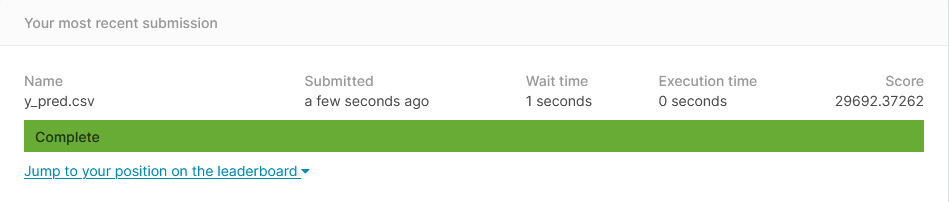

In [36]:
from IPython.display import Image
Image("img/kaggle_score.png")

## Conclusions

### Most Important Features

Unsurprisingly, the two largest continuous features that contribute to housing costs are above ground living space and total basement size. With each increase in 1 square foot, leading to an increase in cost by 20775 and 18305 respectively.

Unfinished basement square footage was one of the largest detractors of house pricing. One strategy might be to look into houses that are ideal but have large unfinished basements, if the cost of redo-ing or finishing the basement is less than the "discount" on the price.

### Desirable Additions

Interestingly, only the top tier of neighbourhoods saw a significant jump in pricing, with the other tiers selected, 2-5 showing a minimal difference in price between the 4.

Garages also increase the price of the house, although having an attached garages saw a decrease. It isn't unusual considering that Ames is not a large city and <a href='https://www.jstor.org/stable/40929500'>vehicle ownership is correlated with suburban centres in America.</a> In the case of building a large apartment complex, it does point to the need for a large carpark area, to accomodate all possible vehicle owners in the complex.

Lastly, wooden decks are also seen as positive additions. One possible contributing reason for this, is the <a href='https://www.forbes.com/sites/larryolmsted/2016/04/28/the-united-states-of-barbecue-americas-love-affair-with-backyard-cooking/?sh=7f7017a15a1d'>love of Americans for backyard barbecues on their decks</a>.

### Further Steps

Unfortunately, the test set contains limited data and data that is somewhat outdated at this point, especially considering the recent rise in house sales and prices in the last two years in the US. Further steps to help improve the model would include:

1. Expanding the time frame of the data to include recent years
2. Including rental prices for each house or for similar houses in the area, so that we can calculate rental prices the houses would also pull
3. One last thing to consider is that student housing is always a steady source of renters. With Iowa State University having a large presence in the town, distance of the house from the university, might be a good predictor of ease of rental in the future.